In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
#import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.mixed_precision import global_policy, set_global_policy, Policy
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, clear_output
import time

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [57]:
# Function to create sequences
# --------------------------------------

def create_sequence(data, target, seq_length):
    Xs, ys = [], []
    for i in range(len(data) - seq_length):
        Xs.append(data[i:i + seq_length])
        ys.append(target[i + seq_length])
    return np.array(Xs), np.array(ys)

In [58]:
# Open velocity data set
# --------------------------------------

ds = xr.open_dataset('/Users/smata/Downloads/processedData/velocityData.nc')


In [59]:
# Reformat to Pandas dataframe
# --------------------------------------

df_u = ds['u'].to_dataframe().reset_index()
df_v = ds['v'].to_dataframe().reset_index()

df_u = df_u.pivot(index = 'time', columns = 'height', values = 'u')
df_v = df_v.pivot(index = 'time', columns = 'height', values = 'v')

df_u.columns = [f'u_{int(height)}m' for height in df_u.columns]
df_v.columns = [f'v_{int(height)}m' for height in df_v.columns]

df = pd.concat([df_u, df_v], axis = 1)
df.reset_index(drop = True, inplace = True)

df.insert(0, 'L',    ds.L.values)
df.insert(0, 'TKE',  ds.TKE.values)

df.insert(0, 'hour_sin', np.sin(2 * np.pi * ds.hr_day.values / 24))
df.insert(0, 'hour_cos', np.cos(2 * np.pi * ds.hr_day.values / 24))

df.insert(0, 'day_sin', np.sin(2 * np.pi * ds.day_yr.values / 365))
df.insert(0, 'day_cos', np.cos(2 * np.pi * ds.day_yr.values / 365))

df


,day_cos,day_sin,hour_cos,hour_sin,TKE,L,u_4m,u_10m,u_20m,u_40m,...,v_1820m,v_1840m,v_1860m,v_1880m,v_1900m,v_1920m,v_1940m,v_1960m,v_1980m,v_2000m
0,0.994671,0.103102,0.321439,0.946930,0.364109,0.026324,-2.658197,-3.134882,-3.929358,-4.672253,...,2.409961,1.774886,1.223201,1.290256,0.981665,0.590465,0.199265,-0.191935,-0.583134,-0.974334
1,0.994671,0.103102,0.258819,0.965926,0.354486,0.026431,-2.680222,-3.192631,-4.046645,-4.814137,...,1.829368,1.411062,1.121279,0.949779,0.778049,0.623042,0.483475,0.343908,0.204342,0.064775
2,0.994671,0.103102,0.195090,0.980785,0.344863,0.026540,-2.702247,-3.250379,-4.163933,-4.956020,...,1.315327,0.890215,0.529345,0.168475,-0.192395,-0.528701,-0.846050,-1.176230,-1.446669,-1.595591
3,0.994671,0.103102,0.130526,0.991445,0.340208,0.025244,-2.765830,-3.304644,-4.202669,-5.055588,...,0.098417,-0.249312,-0.597041,-0.944770,-1.226242,-1.374713,-1.430338,-1.542741,-1.422256,-1.509911
4,0.994671,0.103102,0.065403,0.997859,0.335553,0.024069,-2.829412,-3.358909,-4.241404,-5.155156,...,0.117700,-0.146292,-0.410283,-0.674274,-0.603972,-0.528294,-0.593547,-0.933438,-1.134916,-1.259950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7180,-0.251190,0.967938,-0.195090,-0.980785,1.442880,-0.008578,-1.927838,-2.317655,-2.967349,-3.296596,...,15.014821,14.782911,14.891560,14.942379,14.337900,14.473034,15.139789,14.816848,14.675967,14.680009
7181,-0.251190,0.967938,0.831470,-0.555570,1.837700,-0.003191,-4.345756,-5.113219,-6.392324,-7.251232,...,19.800450,19.748648,19.788210,20.000900,19.782719,19.568625,19.436122,19.270641,19.395428,19.347586
7182,-0.251190,0.967938,0.980785,-0.195090,2.819760,-0.002637,-4.407786,-5.117823,-6.301218,-7.201357,...,22.091687,22.244604,22.475860,23.226757,23.953624,24.299480,24.299480,24.299480,24.299480,24.299480
7183,-0.251190,0.967938,0.991445,-0.130526,2.715415,-0.002294,-4.188309,-4.882257,-6.038836,-6.891900,...,22.036781,22.195851,22.404776,22.566675,22.679079,22.880725,23.123269,23.185785,23.781791,23.913161


In [60]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
day_cos,7185.0,-0.247509,0.630630,-0.999963,-0.847541,-3.171913e-01,0.276097,1.000000
day_sin,7185.0,-0.051136,0.733867,-0.999991,-0.769415,-1.797666e-01,0.763889,0.999991
hour_cos,7185.0,-0.011449,0.709237,-1.000000,-0.751840,6.123234e-17,0.659346,1.000000
hour_sin,7185.0,0.432358,0.556805,-1.000000,0.065403,6.087614e-01,0.896873,1.000000
TKE,7185.0,1.028879,0.983515,0.044153,0.396188,7.000850e-01,1.246320,9.367000
...,...,...,...,...,...,...,...,...
v_1920m,7185.0,5.665480,7.214828,-31.634985,2.312838,5.837031e+00,9.730772,28.926717
v_1940m,7185.0,5.620471,7.202256,-31.448337,2.259828,5.786498e+00,9.696327,28.926717
v_1960m,7185.0,5.577999,7.188496,-31.089634,2.208857,5.722331e+00,9.669410,28.926717
v_1980m,7185.0,5.535838,7.171357,-30.416235,2.162760,5.678521e+00,9.613506,28.926717


In [61]:
# Standardize data
# --------------------------------------

windCols      = [col for col in df.columns if col.startswith('u_') or col.startswith('v_')]
stabilityCols = ['TKE', 'L']

wind_scaler = MinMaxScaler()
df[windCols] = wind_scaler.fit_transform(df[windCols])

stability_scaler = MinMaxScaler()
df[stabilityCols] = stability_scaler.fit_transform(df[stabilityCols])

df


,day_cos,day_sin,hour_cos,hour_sin,TKE,L,u_4m,u_10m,u_20m,u_40m,...,v_1820m,v_1840m,v_1860m,v_1880m,v_1900m,v_1920m,v_1940m,v_1960m,v_1980m,v_2000m
0,0.994671,0.103102,0.321439,0.946930,0.034320,0.599150,0.202103,0.169902,0.154228,0.149628,...,0.565807,0.556945,0.546649,0.545722,0.539544,0.532109,0.524183,0.514821,0.502724,0.489911
1,0.994671,0.103102,0.258819,0.965926,0.033287,0.599312,0.201048,0.167281,0.149505,0.144492,...,0.556469,0.551057,0.544981,0.540125,0.536189,0.532647,0.528891,0.523750,0.515993,0.507637
2,0.994671,0.103102,0.195090,0.980785,0.032255,0.599475,0.199994,0.164660,0.144781,0.139356,...,0.548200,0.542628,0.535295,0.527282,0.520199,0.513630,0.506870,0.498421,0.488172,0.479312
3,0.994671,0.103102,0.130526,0.991445,0.031756,0.597527,0.196949,0.162197,0.143222,0.135752,...,0.528627,0.524185,0.516862,0.508983,0.503164,0.499660,0.497192,0.492314,0.488583,0.480774
4,0.994671,0.103102,0.065403,0.997859,0.031257,0.595761,0.193903,0.159734,0.141662,0.132148,...,0.528937,0.525853,0.519918,0.513429,0.513418,0.513636,0.511052,0.502466,0.493425,0.485038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7180,-0.251190,0.967938,-0.195090,-0.980785,0.150032,0.546686,0.237082,0.206995,0.192968,0.199424,...,0.768553,0.767471,0.770323,0.770130,0.759617,0.761340,0.771645,0.764900,0.759858,0.756962
7181,-0.251190,0.967938,0.831470,-0.555570,0.192382,0.554783,0.121282,0.080108,0.055045,0.056274,...,0.845529,0.847837,0.850454,0.853281,0.849333,0.845478,0.842806,0.839109,0.839386,0.836587
7182,-0.251190,0.967938,0.980785,-0.195090,0.297721,0.555616,0.118311,0.079899,0.058713,0.058079,...,0.882383,0.888233,0.894436,0.906306,0.918057,0.923595,0.923358,0.922900,0.922026,0.921063
7183,-0.251190,0.967938,0.991445,-0.130526,0.286529,0.556132,0.128823,0.090591,0.069279,0.069281,...,0.881499,0.887443,0.893272,0.895456,0.897057,0.900168,0.903877,0.904344,0.913302,0.914473


In [62]:
# Define and extract input and output columns
# --------------------------------------

inputs  = ['day_cos', 'day_sin', 'hour_cos', 'hour_sin', 'TKE', 'L', 'u_10m', 'v_10m']

X = df[inputs].values
y = df[windCols].values

In [63]:
# Create input and output arrays
# --------------------------------------

seq_length = 1
X_sequence, y_sequence = create_sequence(X, y, seq_length)

split_index = int(0.8 * len(X_sequence))

X_train_sequence, X_test_sequence = X_sequence[:split_index], X_sequence[split_index:]
y_train_sequence, y_test_sequence = y_sequence[:split_index], y_sequence[split_index:]

print(X_sequence.shape)
print(y_sequence.shape)

(7184, 1, 8)
(7184, 204)


In [64]:
# Create TensorFlow objects
# --------------------------------------

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_sequence, y_train_sequence))
test_dataset  = tf.data.Dataset.from_tensor_slices((X_test_sequence, y_test_sequence))


In [65]:
# # Define LSTM
# # --------------------------------------

# input_shape = (seq_length, len(inputs))

# model = Sequential()

# model.add(Input(shape = input_shape))
# model.add(LSTM(64, return_sequences = True))
# model.add(LSTM(32))
# model.add(Dense(len(windCols)))

# model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [66]:
# # Train
# # --------------------------------------

# history = model.fit(X_sequence, y_sequence, epochs = 1, batch_size = 128, validation_split = 0.2)

In [67]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


KeyboardInterrupt: 

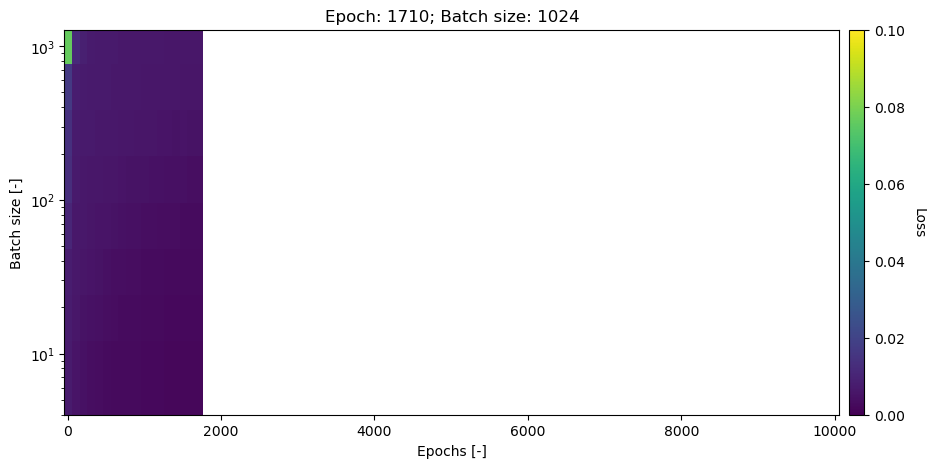

In [68]:
# Train sweep
# --------------------------------------

tf.config.experimental_run_functions_eagerly(False)

policy = Policy('mixed_float16')
set_global_policy(policy)

batch_list = [8, 16, 32, 64, 128, 256, 512, 1024]
epoch_list  = np.arange(10, 10100, 100)

loss = np.nan * np.ones((len(batch_list), len(epoch_list)))

plt.ion()
fig,ax = plt.subplots(figsize = (10, 5))
cb_ax = fig.add_axes([0.91, 0.11, 0.015, 0.77])
ax.set_xlabel("Epochs [-]")
ax.set_ylabel("Batch size [-]")
ax.set_yscale('log')

cntf = ax.pcolormesh(epoch_list, batch_list, loss, cmap = 'viridis', vmin = 0, vmax = 0.1)
cbar = fig.colorbar(cntf, orientation='vertical', cax=cb_ax)
cbar.set_label('Loss', rotation = 270, labelpad = 15)

time.sleep(0.05)

with tf.device('/device:CPU:0'):

    for epoch in range(len(epoch_list)):
        for batch in range(len(batch_list)):

            train_dataset = tf.data.Dataset.from_tensor_slices((X_train_sequence, y_train_sequence))
            test_dataset  = tf.data.Dataset.from_tensor_slices((X_test_sequence, y_test_sequence))

            train_dataset = train_dataset.cache().shuffle(buffer_size=1024).batch(batch_list[batch]).prefetch(tf.data.experimental.AUTOTUNE)
            test_dataset  = test_dataset.cache().batch(batch_list[batch]).prefetch(tf.data.experimental.AUTOTUNE)

            input_shape = (seq_length, len(inputs))

            model = Sequential()

            model.add(Input(shape = input_shape))
            model.add(LSTM(64, return_sequences = True))
            model.add(LSTM(32))
            model.add(Dense(len(windCols)))

            model.compile(optimizer = 'adam', loss = 'mean_squared_error')

            history = model.fit(train_dataset, epochs = epoch_list[epoch], validation_data = test_dataset, verbose = 0)

            loss[batch, epoch] = history.history['loss'][-1]

            cntf.set_array(loss)

            cb_ax.cla()
            cbar = fig.colorbar(cntf, orientation = 'vertical', cax = cb_ax)
            cbar.set_label('Loss', rotation = 270, labelpad = 15)

            cntf.set_clim(0, 0.1)

            ax.set_title(f'Epoch: {epoch_list[epoch]}; Batch size: {batch_list[batch]}')
            display(fig)
            clear_output(wait = True)
            time.sleep(0.05)

plt.ioff()
plt.show()



In [ ]:
# Predict
# --------------------------------------

predictions = model.predict(X_sequence)

predictions = wind_scaler.inverse_transform(predictions)

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


Text(0.5, 0, 'Wind speed [m/s]')

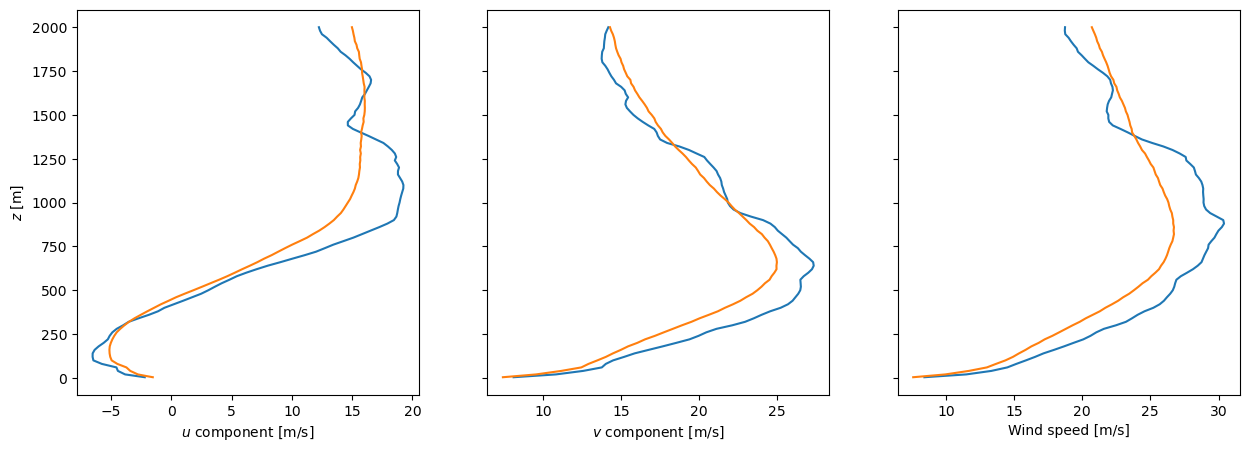

In [ ]:
# Plot sample profiles
# --------------------------------------

i = 2100

fig,ax = plt.subplots(1, 3, figsize = (15, 5), sharey = True)

divider = int(len(outputs)/2)

ax[0].plot(ds.u[:,i], ds.height, label = 'Data')
ax[0].plot(predictions[i,:divider], ds.height, label = 'Model')
ax[0].set_xlabel('$u$ component [m/s]')
ax[0].set_ylabel('$z$ [m]')

ax[1].plot(ds.v[:,i], ds.height, label = 'Data')
ax[1].plot(predictions[i,divider:], ds.height, label = 'Model')
ax[1].set_xlabel('$v$ component [m/s]')

ax[2].plot(((ds.u[:,i]**2 + ds.v[:,i]**2)**(1/2)), ds.height, label = 'Data')
ax[2].plot((predictions[i,divider:]**2 + predictions[i,:divider]**2)**(1/2), ds.height, label = 'Model')
ax[2].set_xlabel('Wind speed [m/s]')


Text(0.5, 0, 'Wind speed [m/s]')

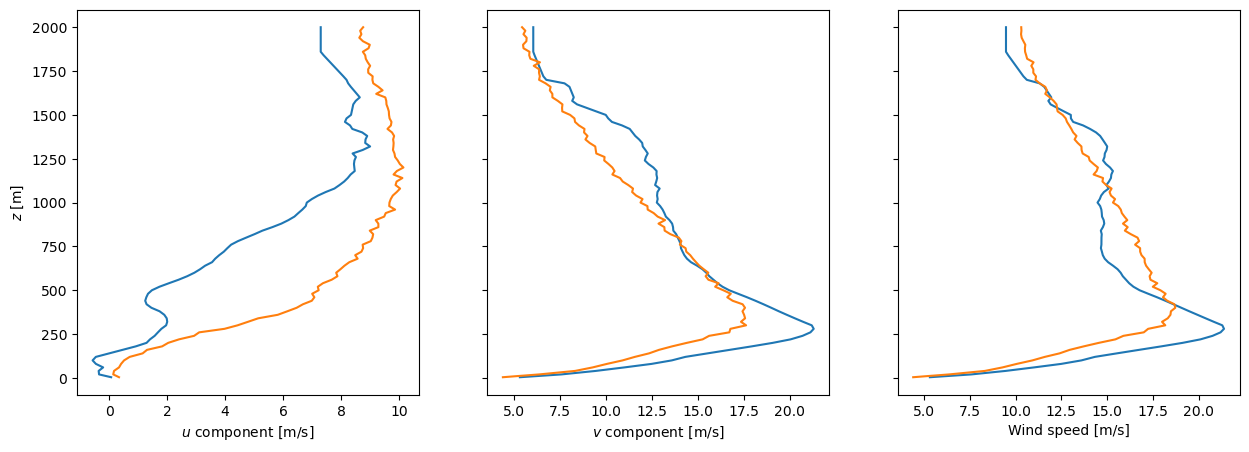

In [ ]:
# Plot sample profiles
# --------------------------------------

i = 150

fig,ax = plt.subplots(1, 3, figsize = (15, 5), sharey = True)

divider = int(len(outputs)/2)

ax[0].plot(ds.u[:,i], ds.height, label = 'Data')
ax[0].plot(predictions[i,:divider], ds.height, label = 'Model')
ax[0].set_xlabel('$u$ component [m/s]')
ax[0].set_ylabel('$z$ [m]')

ax[1].plot(ds.v[:,i], ds.height, label = 'Data')
ax[1].plot(predictions[i,divider:], ds.height, label = 'Model')
ax[1].set_xlabel('$v$ component [m/s]')

ax[2].plot(((ds.u[:,i]**2 + ds.v[:,i]**2)**(1/2)), ds.height, label = 'Data')
ax[2].plot((predictions[i,divider:]**2 + predictions[i,:divider]**2)**(1/2), ds.height, label = 'Model')
ax[2].set_xlabel('Wind speed [m/s]')